In [1]:
import sys 
sys.path.append('..')
from LRL import *

## Environment

In [2]:
import gym
import gym.spaces

In [3]:
INVARIANTS = Tensor(np.load("RubikInvariantsMatrix.npy"))
TRANSITIONS = Tensor(np.load("RubikActionMatrix.npy"))
INVARIANTS.shape, TRANSITIONS.shape

(torch.Size([24, 48, 48]), torch.Size([12, 48, 48]))

In [4]:
class Rubik:
    def __init__(self, num_envs=64, reset_when_done=True, frozen=False, complexity=1000):
        self.action_space = gym.spaces.Discrete(12)
        self.observation_space = gym.spaces.MultiDiscrete([6]*96)
        self.init_state = Tensor([0]*8 + [1]*8 + [2]*8 + [3]*8 + [4]*8 + [5]*8)
        self.num_envs = num_envs
        
        self.group = self.init_state.clone()[None].repeat(self.num_envs, 1)
        self.target = self.init_state.clone()[None].repeat(self.num_envs, 1)
        
        self._all_indices = LongTensor(np.arange(self.num_envs))
        self.frozen = False
        self.reset(complexity=complexity)
        
        self.reset_when_done = reset_when_done
        self.next_states_function = self.next_states
        
        self.frozen = frozen
        if self.frozen:
            self.group_cache = self.group.clone()
            self.target_cache = self.target.clone()
    
    def reset(self, indices=None, complexity=1000):
        if indices is None:
            indices = self._all_indices
        
        if self.frozen:
            self.group[indices] = self.group_cache[indices].clone()
            self.target[indices] = self.target_cache[indices].clone()
        else:
            self.group[indices] = self.init_state.clone()[None].repeat(indices.shape[0], 1)
            for _ in range(1000):
                self.group[indices] = self.turn(self.group[indices], Categorical(Tensor(np.ones(12))).sample((indices.shape[0],)))

            self.target[indices] = self.group[indices].clone()
            for _ in range(complexity):
                self.target[indices] = self.turn(self.target[indices], Categorical(Tensor(np.ones(12))).sample((indices.shape[0],)))
                
        return torch.cat([self.group, self.target], dim=1)
    
    def next_states(self, group):
        """Get batch of all possible next Rubik states (Tensor Bx12x96), next rewards and dones using state (Tensor Bx96)"""
        next_states = TRANSITIONS.matmul(group[:, :48].transpose(0, 1)).permute(2, 0, 1)
        r = -Tensor(np.ones((group.shape[0], 12)))
        done = ((next_states != group[:, None, 48:]).sum(dim=2) == 0).float()
        return torch.cat([next_states, group[:, None, 48:].repeat(1, 12, 1)], dim=2), r, done
    
    def turn(self, group, command):
        """Turns batch of Rubik cubes (Tensor Bx48) using batch of commands (Tensor of size B)"""
        return TRANSITIONS[command].matmul(group.unsqueeze(2)).squeeze(2)
        
    def step(self, command):
        self.group = self.turn(self.group, command)
        
        done = (self.group != self.target).sum(dim=1) == 0
        if done.any() and self.reset_when_done:
            self.reset(self._all_indices[done])
        
        return torch.cat([self.group, self.target], dim=1), \
               -Tensor(np.ones((self.num_envs))), \
               done, {}
                
    def draw(self, group):
        group = list(group.cpu().numpy().astype(int))
        print('.'*3 + ''.join(map(str, group[32:35])) + '.'*6 + '\n' +\
               '.'*3 + str(group[35]) + 'U' + str(group[36]) + '.'*6 + '\n' +\
               '.'*3 + ''.join(map(str, group[37:40])) + '.'*6 + '\n' +\
               ''.join(map(str, group[0:3] + group[8:11] + group[16:19] + group[24:27])) + '\n' +\
               str(group[3]) + 'L' + str(group[4]) + str(group[11]) + 'F' + str(group[12]) + str(group[19]) + 'R' + str(group[20]) + str(group[27]) + 'B' + str(group[28]) + '\n' +\
               ''.join(map(str, group[5:8] + group[13:16] + group[21:24] + group[29:32])) + '\n' +\
               '.'*3 + ''.join(map(str, group[40:43])) + '.'*6 + '\n' +\
               '.'*3 + str(group[43]) + 'D' + str(group[44]) + '.'*6 + '\n' +\
               '.'*3 + ''.join(map(str, group[45:48])) + '.'*6 + '\n')

In [5]:
rubik = Rubik()

In [6]:
rubik.draw(rubik.target[0])

...221......
...5U2......
...053......
413530440513
1L03F25R04B4
545101421003
...212......
...3D3......
...254......



# Сеть

А one_hot кодировки для 6 цветов не оказалось в дефолтных функций пайторча.

In [7]:
def one_hot(x, nb_digits):
    x_onehot = Tensor(x.size()[0]*x.size()[1], nb_digits)
    x_onehot.zero_()
    x_onehot.scatter_(1, x.view(-1, 1).type(torch.cuda.LongTensor), 1)
    return x_onehot.view(x.size()[0], x.size()[1], nb_digits)

Сама сеть. Для каждой конфигурации выдаём 100 фич. По конфигурациям из этих фич берём максимум, дальше небольшой полносвязник. "Крышка" (выдающая всего одно число - value состояния) будет добавлена моей библиотечечкой LRL.

In [8]:
class RubikNet(nn.Module):
    def __init__(self, linear):
        super(RubikNet, self).__init__()
        
        self.invariantial = nn.Sequential(
            linear(48*6*2, 800),
            nn.ReLU(),
            linear(800, 1000),
            nn.ReLU(),
            linear(1000, 1000),
            nn.ReLU(),
            linear(1000, 600),
            nn.ReLU(),
            linear(600, 400),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            linear(400, 200),
            nn.ReLU(),
            linear(200, 80),
            nn.ReLU()
        )

    def forward(self, x):
        '''
        x - Tensor of shape (batch_size, 48)
        48: representation of Cube with number from 0 to 5
        6: colors of the cube
        24: number of invariants of cuberepresentation
        400: feature representation of invariantial part of network
        '''
        #x = torch.cat([INVARIANTS.matmul(x[:, :48].transpose(0, 1)).permute(2, 0, 1).contiguous().view(-1, 48),
        #               x[:, None, 48:].repeat(1, 24, 1).view(-1, 48)], dim=1)
        x = one_hot(x, 6).view(-1, 2*48*6)
        
        x = self.invariantial(x)#.view(-1, 24, 400)
        #x = x.max(dim=1)[0]
        return self.fc(x)

# Agent

In [9]:
class Agent():
    """
    Basic agent interface for interacting with enviroment
    
    Args:
        env - environment
        make_env - function returning function to create a new instance of environment. Accepts seed (int) as parameter
        threads - number of environments to create with make_envs, int
        seed - seed for torch, numpy, torch.cuda and environments, int
    """
    
    def __init__(self, config):
        self.config = config
        
        # creating environment
        self.env = config["env"]
        
        # useful config updates
        self.config["num_actions"] = 12
        self.config["observation_shape"] = (96,)
        
        # logging and initialization
        self.initialized = False          
        self.frames_done = 0
        
        self.logger = defaultdict(list)
        self.logger_labels = defaultdict(tuple)
        self.logger_labels["rewards"] = ("episode", "reward")
        self.logger_labels["fps"] = ("training epoch", "FPS")
    
    def act(self, state):
        """
        Responce on array of observations of enviroment
        input: state, numpy array of size num_envs x observation_shape
        output: actions, list of size num_envs
        """
        return [self.env.action_space.sample() for _ in range(state.shape[0])]
    
    def see(self, state, action, reward, next_state, done):
        """
        Learning from new transition observed:
        input: state, numpy array of size num_envs x observation_shape
        input: action, numpy array of ints of size num_envs
        input: reward, numpy array of size num_envs
        input: next_state, numpy array of size num_envs x observation_shape
        input: done, numpy array of size num_envs of 0 and 1
        """
        self.frames_done += self.env.num_envs
        
    def record_init(self):
        """Initialize buffer for recording game"""
        self.record = defaultdict(list)
        self.record["frames"].append(self.env.render(mode = 'rgb_array'))
    
    def record_step(self):
        """Record one step of game"""
        self.record["frames"].append(self.env.render(mode = 'rgb_array'))
        
    def show_record(self):
        """Show animation"""
        show_frames(self.record["frames"])
    
    def play(self, render=False, record=False):
        """
        Play one game.
        If env is vectorized, first environment's game will be recorded.
        input: render, bool - whether to draw game inline
        input: record, bool - whether to store the game and show aftermath as animation
        output: cumulative reward
        """
        self.is_learning = False
        
        ob = self.env.reset()
        prev_ob = ob
        R = np.zeros((self.env.num_envs), dtype=np.float32)        
        
        if record:
            self.record_init()
        
        for t in count():
            a = self.act(ob)
            ob, r, done, info = self.env.step(a)
            
            #if self.is_learning:
            #    self.see(prev_ob, a, r, ob, done)
            
            R += r
            prev_ob = ob
            
            if record:                
                self.record_step()
            if render:
                clear_output(wait=True)
                img = plt.imshow(self.env.render(mode='rgb_array'))
                plt.show()
            
            if done[0]:
                break
                
        if record:
            self.show_record()
        
        return R[0]
        
    def learn(self, frames_limit=1000):
        """
        Play frames_limit frames for several games in parallel
        input: frames_limit, how many observations to obtain
        """
        
        if not self.initialized:
            self.ob = self.env.reset()       
            self.prev_ob = self.ob
            self.R = Tensor(np.zeros((self.env.num_envs), dtype=np.float32))
            self.initialized = True
        
        self.is_learning = True
        start = time.time()
        frames_limit = (frames_limit // self.env.num_envs) * self.env.num_envs    

        for t in range(frames_limit // self.env.num_envs):
            a = self.act(self.ob)
            self.ob, r, done, info = self.env.step(a)
            
            self.see(self.prev_ob, a, r, self.ob, done)
            
            self.R += r
            for res in self.R[done]:
                print(done)
                self.logger["rewards"].append(res)
                
            self.R[done] = 0
            self.prev_ob = self.ob
        
        self.logger["fps"].append(frames_limit / (time.time() - start))
    
    def write(self, f):
        "writing logs and data to file"
        pickle.dump(self.frames_done, f)
        pickle.dump(self.logger, f)
        
    def read(self, f):
        "reading logs and data from file"
        self.frames_done = pickle.load(f)
        self.logger = pickle.load(f)
        
    def save(self, name):
        "saving to file"
        f = open(name, 'wb')
        self.write(f)
        f.close()   
        
    def load(self, name):
        "loading from file"
        f = open(name, 'rb')
        self.read(f)
        f.close()

In [10]:
def A2C(parclass):
    """Requires parent class, inherited from Agent."""

    class A2C(parclass):
        """
        Advantage Actor-Critic algorithm (A2C).
        Requires parent class inherited from Agent.
        Based on: https://arxiv.org/abs/1602.01783

        Args:
            FeatureExtractorNet - class inherited from nn.Module
            ActorCriticHead - class of Actor-Critic network head, ActorCriticHead or SeparatedActorCriticHead
            magnitude_logging_fraction - number of frames between magnitude logging (it's expensive to do each iteration), int
            rollout - number of frames for one iteration of updating NN weights
            gamma - infinite horizon protection, float, from 0 to 1
            entropy_loss_weight - weight of additional entropy loss
            critic_loss_weight - weight of critic loss
            optimizer - class inherited from torch.optimizer, Adam by default
            optimizer_args - arguments for optimizer, dictionary
            grad_norm_max - maximum of gradient norm
        """
        __doc__ += parclass.__doc__

        def __init__(self, config):
            super().__init__(config)
            self.gamma = config.get("gamma", 0.99)
            self.critic_loss_weight = config.get("critic_loss_weight", 1)
            self.entropy_loss_weight = config.get("entropy_loss_weight", 0)
            self.rollout = config.get("rollout", 5)
            self.grad_norm_max = config.get("grad_norm_max", None)
            self.magnitude_logging_fraction = config.get("magnitude_logging_fraction", 1000)

            self.policy = self.init_network()
            self.optimizer = config.get("optimizer", optim.Adam)(self.policy.parameters(), **config.get("optimizer_args", {}))

            self.observations = Tensor(size=(self.rollout + 1, self.env.num_envs*2, *config["observation_shape"])).zero_()
            self.rewards = Tensor(size=(self.rollout, self.env.num_envs*2, 1)).zero_()
            self.actions = LongTensor(size=(self.rollout + 1, self.env.num_envs*2, 1)).zero_()
            self.dones = Tensor(size=(self.rollout + 1, self.env.num_envs*2, 1)).zero_()
            self.returns = Tensor(size=(self.rollout + 1, self.env.num_envs*2, 1)).zero_()
            self.step = 0

            self.logger_labels["actor_loss"] = ("training iteration", "loss")
            self.logger_labels["critic_loss"] = ("training iteration", "loss")
            self.logger_labels["entropy_loss"] = ("training iteration", "-entropy")
            if self.config.get("linear_layer", nn.Linear) is NoisyLinear:
                self.logger_labels["magnitude"] = ("training epoch", "noise magnitude")

        def init_network(self):
            '''create a new ActorCritic-network'''
            net = self.config.get("ActorCriticHead", ActorCriticHead)(self.config)        
            net.after_init()
            return net

        def act(self, s):
            if self.is_learning:
                self.policy.train()
            else:
                self.policy.eval()

            with torch.no_grad():
                dist, values = self.policy(s)
                actions = dist.sample().view(-1, 1)

            return actions.view(-1)

        def see(self, state, action, reward, next_state, done):
            super().see(state, action, reward, next_state, done)

            self.observations[self.step, :self.env.num_envs].copy_(state)
            self.observations[self.step + 1, :self.env.num_envs].copy_(next_state)
            self.actions[self.step, :self.env.num_envs].copy_(action.view(-1, 1))
            self.rewards[self.step, :self.env.num_envs].copy_(reward.view(-1, 1))
            self.dones[self.step + 1, :self.env.num_envs].copy_(done.view(-1, 1))
            
            self.observations[self.step, self.env.num_envs:].copy_(state)
            self.observations[self.step + 1, self.env.num_envs:].copy_(next_state)
            self.actions[self.step, self.env.num_envs:].copy_(action.view(-1, 1))
            self.rewards[self.step, self.env.num_envs:].copy_(reward.view(-1, 1))
            self.dones[self.step + 1, self.env.num_envs:].copy_(done.view(-1, 1))

            self.step = (self.step + 1) % self.rollout        
            if self.step == 0:
                self.update()

            if (self.frames_done % self.magnitude_logging_fraction < self.env.num_envs and
                self.config.get("linear_layer", nn.Linear) is NoisyLinear):         # TODO and if it is subclass?
                self.logger["magnitude"].append(self.policy.magnitude())

        def compute_returns(self, values):
            '''
            Fills self.returns using self.rewards, self.dones
            input: values, Tensor, num_steps + 1 x num_processes x 1
            '''
            self.returns[-1] = values[-1]
            for step in reversed(range(self.rewards.size(0))):
                self.returns[step] = self.returns[step + 1] * self.gamma * (1 - self.dones[step + 1]) + self.rewards[step]

        def update(self):
            """One step of optimization based on rollout memory"""
            self.policy.train()

            obs_shape = self.observations.size()[2:]
            num_steps, num_processes, _ = self.rewards.size()

            dist, values = self.policy(self.observations.view(-1, *obs_shape))
            action_log_probs = dist.log_prob(self.actions.view(-1))
            dist_entropy = dist.entropy()[:-1].mean()

            values = values.view(num_steps + 1, num_processes, 1)
            action_log_probs = action_log_probs.view(num_steps + 1, num_processes, 1)[:-1]    

            self.compute_returns(values)

            advantages = self.returns[:-1].detach() - values[:-1]
            critic_loss = advantages.pow(2).mean()
            actor_loss = -(advantages.detach() * action_log_probs).mean()

            loss = actor_loss + self.critic_loss_weight * critic_loss - self.entropy_loss_weight * dist_entropy

            self.optimizer.zero_grad()
            loss.backward()
            if self.grad_norm_max is not None:
                torch.nn.utils.clip_grad_norm_(self.policy.parameters(), self.grad_norm_max)
            self.optimizer.step()

            self.logger["actor_loss"].append(actor_loss.item())
            self.logger["critic_loss"].append(critic_loss.item())
            self.logger["entropy_loss"].append(dist_entropy.item())

        def load(self, name, *args, **kwargs):
            super().load(name, *args, **kwargs)
            self.policy.load_state_dict(torch.load(name + "-net"))

        def save(self, name, *args, **kwargs):
            super().save(name, *args, **kwargs)
            torch.save(self.policy.state_dict(), name + "-net")
    return A2C

In [11]:
def GAE(parclass):
    """Requires parent class, inherited from Agent.
    Already inherits from A2C"""

    class GAE(A2C(parclass)):
        """
        Generalized Advantage Estimation (GAE) upgrade of A2C.
        Based on: https://arxiv.org/abs/1506.02438

        Args:
            gae_tau - float, from 0 to 1
        """
        __doc__ += A2C(parclass).__doc__

        def __init__(self, config):
            super().__init__(config)
            self.gae_tau = config.get("gae_tau", 0.95)

        def compute_returns(self, values):
            gae = 0
            for step in reversed(range(self.rewards.size(0))): # just some arithmetics ;)
                delta = self.rewards[step] + self.gamma * values[step + 1] * (1 - self.dones[step + 1]) - values[step]
                gae = delta + self.gamma * self.gae_tau * (1 - self.dones[step + 1]) * gae
                self.returns[step] = gae + values[step]
    return GAE

## HER: Hindsight Experience Replay

In [12]:
class PGHER(GAE(Agent)):
    """
    Substuting rollout... as in HER
    """
    __doc__ += GAE.__doc__
    
    def update(self):
        # for now: no done accounting, seems we are not going to meet them anyway...
        target = self.observations[-1, :self.env.num_envs, :48]
        for i in range(len(self.observations)):
            self.observations[i, self.env.num_envs:, 48:].copy_(target)
        
        self.dones[-1, self.env.num_envs:] += 1
        
        super().update()

# Валидация

In [13]:
def TestingRubiks(parclass):
    """
    Each 20-th iteration launches testing on rubik.
    For logging only, doesn't affect learning procedure.
    """

    class TestingRubiks(parclass):
        __doc__ += parclass.__doc__
        
        def __init__(self, config):
            super().__init__(config)
            GodNumber=26
            self.testing_rubiks = [Rubik(num_envs=512, reset_when_done=False, frozen=True, complexity=i+1) for i in tqdm(range(GodNumber))]
            
            self.testing_frequency= config.get("testing_frequency", 20) 
            for i in range(GodNumber):            
                #self.logger_labels["max_values" + str(i)] = ("testing moment", "value")
                #self.logger_labels["median_values" + str(i)] = ("testing moment", "value")
                self.logger_labels["results" + str(i)] = ("testing moment", "success rate")
        
        def test(self):
            for i, testing_rubik in enumerate(self.testing_rubiks):
                s = testing_rubik.reset(complexity=i+1)

                done = Tensor(np.zeros((testing_rubik.num_envs)))
                for t in range(i+1):
                    s, _, done_now, _ = testing_rubik.step(agent.act(s))
                    done += done_now.float()

                    #if t == 0:
                        #self.logger["max_values" + str(i)].append(agent.qualities.max(dim=1)[0].median().item())
                        #self.logger["median_values" + str(i)].append(agent.qualities.median(dim=1)[0].median().item())

                self.logger["results" + str(i)].append((done > 0).sum().item() / testing_rubik.num_envs)
        
        def see(self, *args, **kwargs):
            super().see(*args, **kwargs)
            
            if self.frames_done % self.testing_frequency < self.env.num_envs:
                self.test()

    return TestingRubiks      

# Агент

In [14]:
from tqdm import tqdm

In [15]:
config = {
    "env": rubik,
    "FeatureExtractor": RubikNet,
    "rollout": 5,
    "gamma": 1,
    "optimizer": optim.RMSprop,
    "optimizer_args": {"lr": 1e-4, "alpha": 0.99, "eps": 1e-5},
    "critic_loss_weight": 1,
    "entropy_loss_weight": 0.01,
    "grad_norm_max": 1,
    "testing_frequency": 51200
}

In [16]:
agent = TestingRubiks(PGHER)(config)

100%|██████████████████████████████████████████| 26/26 [01:40<00:00,  3.88s/it]


In [17]:
for t in tqdm(count()):
    agent.learn(2560)
    plot_durations(agent)
    
    #if t % 10 == 9:
        #agent.save("Navigating RC with HER randomized memory")

KeyboardInterrupt: 

# Результаты с прошлого эксперимента для сравнения

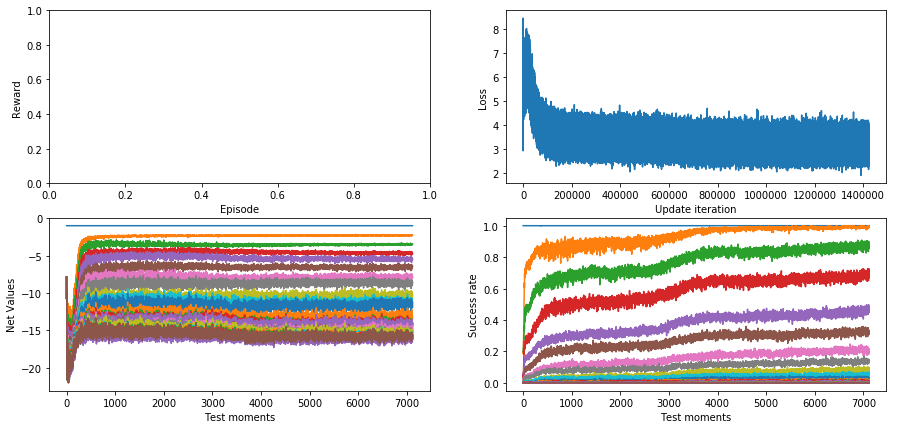

In [24]:
plot_durations(agent)

7118 итераций по 20 шагов КР по 10 шагов оптимизации в каждом. target_update = 10, batch_size=32

1 400 000 итераций обучения нейросети.

Adam{"lr": 0.0001, "eps": 1e-6}

Итоги:
* 100%
* 100%
* 89%
* 71%
* 46%
* 33%
* 21%
* 14%
* 7%
* 6%
* 3%
* 2%
* 1%
* 1%
* 1%

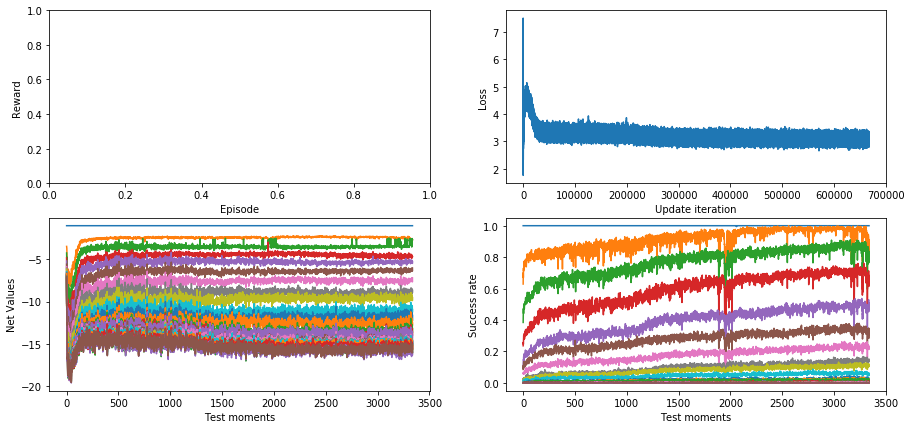

In [17]:
plot_durations(agent)

In [23]:
np.array(agent.results).max(axis=1)

array([1.        , 1.        , 0.91015625, 0.76171875, 0.53710938,
       0.37890625, 0.26367188, 0.16796875, 0.1328125 , 0.08789062,
       0.046875  , 0.03710938, 0.02929688, 0.015625  , 0.01367188,
       0.01171875, 0.0078125 , 0.00390625, 0.00390625, 0.00195312,
       0.00195312, 0.00195312, 0.00195312, 0.00195312, 0.00195312,
       0.        ])

3338 итераций по 20 шагов КР по 10 шагов оптимизации в каждом. target_update = 10, batch_size=512

650 000 итераций обучения нейросети.

Adam{"lr": 0.001, "eps": 1e-6}

В конце слетело. Отображаю лучшие результаты по скрэмблингам:

Итоги:
* 100%
* 100%
* 91%
* 76%
* 54%
* 38%
* 26%
* 17%
* 13%
* 9%
* 5%
* 4%
* 3%
* 2%
* 1%
* 1%
* 1%

### Проверка адекватности

In [205]:
state_b, action_b, reward_b, next_state_b, done_b, weights_b = agent.sample(32)

In [206]:
agent.policy_net.train()
q_values      = agent.policy_net.gather(agent.policy_net(state_b), action_b)
q_values

tensor([-7.8854, -1.0000, -7.6347, -6.5247, -1.0000, -7.7478, -6.9135, -6.9974,
        -8.1851, -8.2715, -8.3163, -6.8112, -6.9829, -6.3643, -7.7549, -1.0000,
        -8.8644, -7.3839, -6.3680, -8.3290, -7.7291, -7.0270, -7.4781, -1.0000,
        -6.5702, -6.9451, -7.7924, -9.5184, -7.6018, -7.2025, -8.3172, -7.2103],
       device='cuda:0', grad_fn=<SqueezeBackward1>)

In [207]:
with torch.no_grad():
    target_q_values = agent.batch_target(reward_b, next_state_b, done_b)
    targets_b = torch.max(target_q_values, weights_b)

In [208]:
loss_b = agent.get_loss(targets_b, q_values)
loss_b = loss_b[loss_b > 0]

In [209]:
gradients = []
for i in range(len(loss_b)):
    agent.optimizer.zero_grad()
    loss_b[i].backward(retain_graph=True)
    gradients.append(torch.cat([tensor.grad.view(-1) for tensor in agent.policy_net.parameters()])[None])

In [210]:
batch_grads = torch.cat(gradients)

In [211]:
def correct_direction(batch_grads):
    for bs in [20, 100]:
        for learning_rate in [0.0001, 0.001, 0.01, 0.1]:
            w = Tensor(loss_b.shape[0]).zero_() + 1. / loss_b.shape[0]
            w.requires_grad = True

            print("LR: ", learning_rate)
            subopt = optim.SGD([w], lr=learning_rate)

            for step in range(bs):
                loss = batch_grads.detach().mv(-batch_grads.detach().transpose(0,1).mv(w.softmax(dim=0))).max()
                print(loss)

                if loss < 0:
                    return w.softmax(dim=0)

                subopt.zero_grad()
                loss.backward()
                subopt.step()
        else:
            print("FAIL")
            
w = correct_direction(batch_grads)

LR:  0.0001
tensor(1202.4884, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1023.1649, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(838.5149, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(648.4572, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(452.9427, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(251.9585, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(45.5319, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(130.6658, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(5.5952, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(163.3771, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(25.2126, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(134.5632, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(57.3527, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(95.1549, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(89.6478, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(55.5491, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(122.0970, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1

tensor(7707.9375, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(6742.8647, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(6341.1831, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(6083.9712, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(6023.9854, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(5986.5659, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(5902.3931, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(5445.9854, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(850.1929, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(930.8409, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(930.8372, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(930.8333, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(930.8297, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(930.8260, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(930.8226, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(930.8192, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(930.8157, device='cuda:0', grad_fn=<MaxBackward1>)
tensor

In [183]:
w

tensor([0.0075, 0.0066, 0.0076, 0.0085, 0.0093, 0.0979, 0.0086, 0.0071, 0.0071,
        0.0064, 0.0073, 0.0082, 0.0103, 0.0070, 0.0070, 0.0095, 0.0104, 0.0076,
        0.0065, 0.0082, 0.0090, 0.0088, 0.0074, 0.3328, 0.0077, 0.0069, 0.3549,
        0.0085, 0.0081, 0.0071], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [143]:
loss = (loss_b * w).sum()
agent.optimizer.zero_grad()
loss.backward()
#torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), self.grad_norm_max)
agent.optimizer.step()

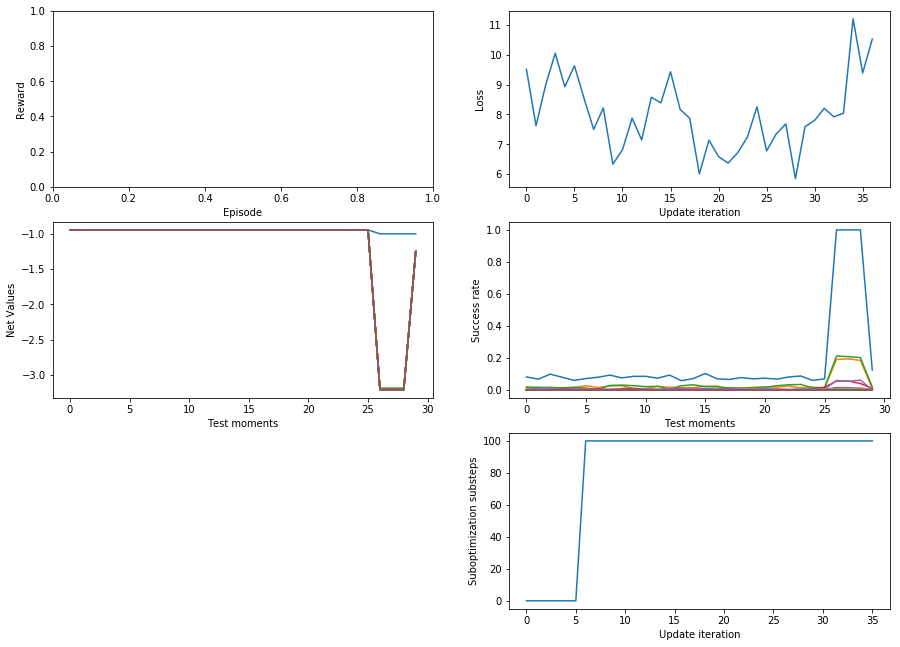

In [145]:
plot_durations(agent)

In [116]:
agent.policy_net.train()
q_values      = agent.policy_net.gather(agent.policy_net(state_b), action_b)
q_values = q_values[mask]
loss_b = agent.get_loss(targets_b, q_values)
loss_b

RuntimeError: input and target shapes do not match: input [30], target [32] at c:\programdata\miniconda3\conda-bld\pytorch_1532505617613\work\aten\src\thcunn\generic/SmoothL1Criterion.cu:12

In [94]:
loss_b.mean()

tensor(2.6200, device='cuda:0', grad_fn=<MeanBackward1>)

In [26]:
for i in range(32):
    ns = rubik.next_states_function(state_b[i:i+1])[0][0]
    for j in range(12):
        if (ns[j] != next_state_b[i:i+1]).max() == 0:
            break
    else:
        print("problem!")